In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
import torch

# Load the CSV file into a pandas DataFrame
df = pd.read_csv("/content/cleaned_ghc_train.csv")


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

df['text'] = df['text'].fillna('')

In [ ]:
y = df['label']
X=df['text']

# **Bidirectional LSTM**

Epoch 1/5
273/273 [==============================] - 64s 205ms/step - loss: 0.6324 - accuracy: 0.6630 - val_loss: 0.6069 - val_accuracy: 0.7792
Epoch 2/5
273/273 [==============================] - 34s 125ms/step - loss: 0.4604 - accuracy: 0.8308 - val_loss: 0.4670 - val_accuracy: 0.8083
Epoch 3/5
273/273 [==============================] - 30s 110ms/step - loss: 0.3664 - accuracy: 0.8608 - val_loss: 0.4174 - val_accuracy: 0.8352
Epoch 4/5
273/273 [==============================] - 29s 108ms/step - loss: 0.2891 - accuracy: 0.8928 - val_loss: 0.4255 - val_accuracy: 0.8237
Epoch 5/5
273/273 [==============================] - 30s 108ms/step - loss: 0.2293 - accuracy: 0.9088 - val_loss: 0.4495 - val_accuracy: 0.8225
137/137 - 5s - loss: 0.4495 - accuracy: 0.8225 - 5s/epoch - 34ms/step

Test accuracy: 0.8225436210632324
137/137 [==============================] - 5s 28ms/step


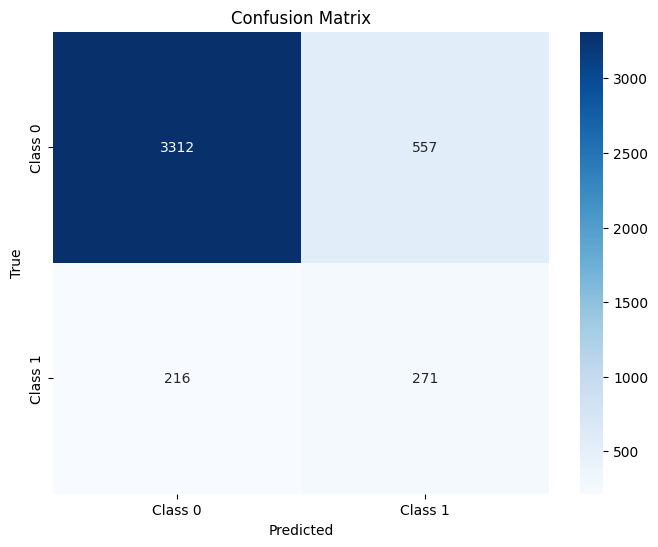

              precision    recall  f1-score   support

     Class 0       0.94      0.86      0.90      3869
     Class 1       0.33      0.56      0.41       487

    accuracy                           0.82      4356
   macro avg       0.63      0.71      0.65      4356
weighted avg       0.87      0.82      0.84      4356



In [ ]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X and y are your dataset features and labels
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
top_words = 10000
max_review_length = 600

# Tokenization
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_review_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_review_length)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
embedding_vector_length = 100  # Increase embedding dimension
# Define the model
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=top_words, output_dim=embedding_vector_length, input_length=max_review_length))

# Add Dropout for regularization
model.add(Dropout(0.5))

# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Dropout(0.5))  # Add Dropout for regularization

# Another LSTM layer
model.add(Bidirectional(LSTM(units=64)))
model.add(Dropout(0.5))  # Add Dropout for regularization

# Dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Add Dropout for regularization
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping and class weights
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=64,
                    validation_data=(X_test_padded, y_test),
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_padded, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# Predict the labels for the test set
y_pred = model.predict(X_test_padded)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred_classes, target_names=['Class 0', 'Class 1']))


# **CNN with BLSTM**

Epoch 1/5
273/273 [==============================] - 42s 121ms/step - loss: 0.6072 - accuracy: 0.6921 - val_loss: 0.4356 - val_accuracy: 0.8414
Epoch 2/5
273/273 [==============================] - 23s 83ms/step - loss: 0.4282 - accuracy: 0.8393 - val_loss: 0.5227 - val_accuracy: 0.7759
Epoch 3/5
273/273 [==============================] - 21s 77ms/step - loss: 0.2891 - accuracy: 0.8824 - val_loss: 0.4645 - val_accuracy: 0.8205
Epoch 4/5
273/273 [==============================] - 20s 74ms/step - loss: 0.1830 - accuracy: 0.9215 - val_loss: 0.5761 - val_accuracy: 0.7736
Epoch 5/5
273/273 [==============================] - 20s 71ms/step - loss: 0.1340 - accuracy: 0.9442 - val_loss: 0.6574 - val_accuracy: 0.7957
137/137 - 2s - loss: 0.6574 - accuracy: 0.7957 - 2s/epoch - 17ms/step

Test accuracy: 0.7956840991973877
137/137 [==============================] - 3s 16ms/step


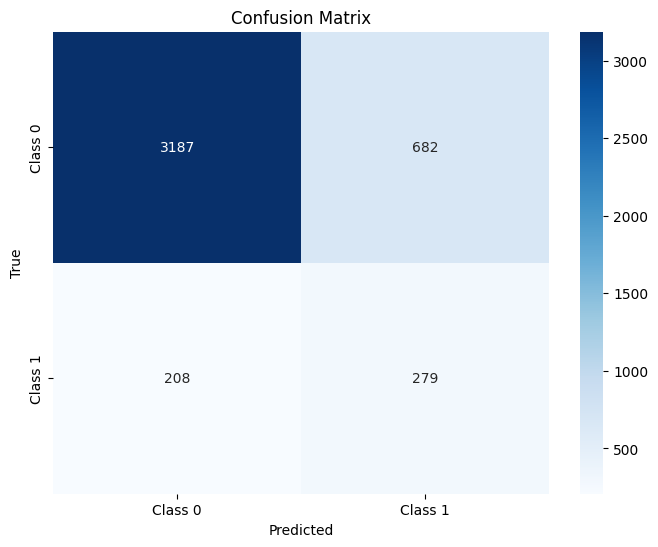

              precision    recall  f1-score   support

     Class 0       0.94      0.82      0.88      3869
     Class 1       0.29      0.57      0.39       487

    accuracy                           0.80      4356
   macro avg       0.61      0.70      0.63      4356
weighted avg       0.87      0.80      0.82      4356



In [ ]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X and y are your dataset features and labels
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
top_words = 10000
max_review_length = 600

# Tokenization
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_review_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_review_length)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
embedding_vector_length = 100  # Increase embedding dimension

# Define the model
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=top_words, output_dim=embedding_vector_length, input_length=max_review_length))

# CNN layer
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))  # Add Dropout for regularization

# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Dropout(0.5))  # Add Dropout for regularization

# Another LSTM layer
model.add(Bidirectional(LSTM(units=64)))
model.add(Dropout(0.5))  # Add Dropout for regularization

# Dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Add Dropout for regularization
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping and class weights
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=64,
                    validation_data=(X_test_padded, y_test),
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_padded, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# Predict the labels for the test set
y_pred = model.predict(X_test_padded)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred_classes, target_names=['Class 0', 'Class 1']))
